# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.00090499 -0.1928352  -0.03145304  0.32617311] 0 1.0 False {}
state, action, reward, done, info
[-0.0047617   0.00272012 -0.02492958  0.02373954] 1 1.0 False {}
state, action, reward, done, info
[-0.00470729  0.19819055 -0.02445479 -0.27670353] 1 1.0 False {}
state, action, reward, done, info
[-0.00074348  0.00342587 -0.02998886  0.00816714] 0 1.0 False {}
state, action, reward, done, info
[-0.00067497  0.19896478 -0.02982552 -0.29382475] 1 1.0 False {}
state, action, reward, done, info
[ 0.00330433  0.39449898 -0.03570201 -0.59576301] 1 1.0 False {}
state, action, reward, done, info
[ 0.01119431  0.59010192 -0.04761727 -0.89947461] 1 1.0 False {}
state, action, reward, done, info
[ 0.02299635  0.78583572 -0.06560676 -1.20673671] 1 1.0 False {}
state, action, reward, done, info
[ 0.03871306  0.98174112 -0.0897415  -1.51923717] 1 1.0 False {}
state, action, reward, done, info
[ 0.05834789  1.17782615 -0.12012624 -1.83852972] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.177826153139452 -1.838529723915487


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, next_states, actions, targetQs

In [8]:
# Q: qfunction/encoder
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits_actions)

        # return actions logits
        return logits

In [9]:
# G: generator/ decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [10]:
# D: descriminator/reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [11]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Q-learning: Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, d_loss, g_loss, rewards_fake, rewards_real

In [12]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt 

In [13]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.d_loss, self.g_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            next_states=self.next_states, hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 2.0 Average reward fake: 0.4857206344604492 Average reward real: 0.48793157935142517 Training d_loss: 1.3826 Training g_loss: 0.7213 Training q_loss: 0.3421 Explore P: 0.9998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 19.0 Average reward fake: 0.4790409207344055 Average reward real: 0.5361893773078918 Training d_loss: 1.2777 Training g_loss: 0.7402 Training q_loss: 0.5650 Explore P: 0.9979
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9.0 Average reward fake: 0.4861293435096741 Average reward real: 0.5334004163742065 Training d_loss: 1.2992 Training g_loss: 0.7248 Training q_loss: 1.2741 Explore P: 0.9970
-

-------------------------------------------------------------------------------
Episode: 23 Total reward: 37.0 Average reward fake: 0.07496147602796555 Average reward real: 0.8563590049743652 Training d_loss: 0.2776 Training g_loss: 2.6004 Training q_loss: 36.1427 Explore P: 0.9533
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 20.0 Average reward fake: 0.04531712085008621 Average reward real: 0.925586998462677 Training d_loss: 0.1295 Training g_loss: 3.1313 Training q_loss: 711.0956 Explore P: 0.9514
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 22.0 Average reward fake: 0.03569464758038521 Average reward real: 0.9571079015731812 Training d_loss: 0.0811 Training g_loss: 3.3664 Training q_loss: 1904.9053 Explore

-------------------------------------------------------------------------------
Episode: 46 Total reward: 18.0 Average reward fake: 0.0012542642652988434 Average reward real: 0.9988151788711548 Training d_loss: 0.0024 Training g_loss: 6.6910 Training q_loss: 706.6235 Explore P: 0.9079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 9.0 Average reward fake: 0.001158001134172082 Average reward real: 0.9985052943229675 Training d_loss: 0.0027 Training g_loss: 6.7720 Training q_loss: 19.1774 Explore P: 0.9070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 16.0 Average reward fake: 0.0009750787867233157 Average reward real: 0.9936079978942871 Training d_loss: 0.0075 Training g_loss: 6.9384 Training q_loss: 911.0749 Exp

-------------------------------------------------------------------------------
Episode: 69 Total reward: 18.0 Average reward fake: 0.11191314458847046 Average reward real: 0.9220808744430542 Training d_loss: 0.3312 Training g_loss: 5.2811 Training q_loss: 1093.0222 Explore P: 0.8682
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 13.0 Average reward fake: 0.23422174155712128 Average reward real: 0.7822372317314148 Training d_loss: 0.8907 Training g_loss: 3.7306 Training q_loss: 2612.0793 Explore P: 0.8671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 20.0 Average reward fake: 0.16909615695476532 Average reward real: 0.7002133727073669 Training d_loss: 0.7023 Training g_loss: 3.4263 Training q_loss: 2686.6580 Exp

-------------------------------------------------------------------------------
Episode: 92 Total reward: 17.0 Average reward fake: 0.22489003837108612 Average reward real: 0.5890467166900635 Training d_loss: 0.9612 Training g_loss: 1.5748 Training q_loss: 1513.7434 Explore P: 0.8256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 11.0 Average reward fake: 0.2837497889995575 Average reward real: 0.831872284412384 Training d_loss: 0.5809 Training g_loss: 1.2960 Training q_loss: 85043.9141 Explore P: 0.8247
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 32.0 Average reward fake: 0.4360080659389496 Average reward real: 0.7237445116043091 Training d_loss: 0.9768 Training g_loss: 0.8569 Training q_loss: 1060.9236 Explo

-------------------------------------------------------------------------------
Episode: 115 Total reward: 14.0 Average reward fake: 0.1790730059146881 Average reward real: 0.5370428562164307 Training d_loss: 0.9327 Training g_loss: 1.7778 Training q_loss: 898.9618 Explore P: 0.7890
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 48.0 Average reward fake: 0.3045367896556854 Average reward real: 0.7632613182067871 Training d_loss: 0.7294 Training g_loss: 1.2031 Training q_loss: 33292.9258 Explore P: 0.7853
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 17.0 Average reward fake: 0.3115319609642029 Average reward real: 0.7854615449905396 Training d_loss: 0.6964 Training g_loss: 1.1647 Training q_loss: 6486.5757 Exp

-------------------------------------------------------------------------------
Episode: 138 Total reward: 24.0 Average reward fake: 0.3221326470375061 Average reward real: 0.5310887098312378 Training d_loss: 1.1072 Training g_loss: 1.1356 Training q_loss: 217.9126 Explore P: 0.7540
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 26.0 Average reward fake: 0.376272052526474 Average reward real: 0.512431263923645 Training d_loss: 1.2898 Training g_loss: 1.0273 Training q_loss: 89.7060 Explore P: 0.7520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 23.0 Average reward fake: 0.7147653698921204 Average reward real: 0.48251086473464966 Training d_loss: 2.1943 Training g_loss: 0.3806 Training q_loss: 170.9080 Explore 

-------------------------------------------------------------------------------
Episode: 161 Total reward: 38.0 Average reward fake: 0.47569188475608826 Average reward real: 0.5328116416931152 Training d_loss: 1.2985 Training g_loss: 0.7597 Training q_loss: 800.6892 Explore P: 0.7163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 13.0 Average reward fake: 0.47547999024391174 Average reward real: 0.5146859288215637 Training d_loss: 1.3276 Training g_loss: 0.7524 Training q_loss: 108.6393 Explore P: 0.7154
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 34.0 Average reward fake: 0.5025621652603149 Average reward real: 0.5047529935836792 Training d_loss: 1.3953 Training g_loss: 0.6974 Training q_loss: 167.5672 Expl

-------------------------------------------------------------------------------
Episode: 184 Total reward: 26.0 Average reward fake: 0.5167390704154968 Average reward real: 0.5160118341445923 Training d_loss: 1.3918 Training g_loss: 0.6632 Training q_loss: 99.7986 Explore P: 0.6574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 66.0 Average reward fake: 0.519392728805542 Average reward real: 0.4848322868347168 Training d_loss: 1.4623 Training g_loss: 0.6620 Training q_loss: 237.2868 Explore P: 0.6532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 17.0 Average reward fake: 0.5101035833358765 Average reward real: 0.5147465467453003 Training d_loss: 1.3789 Training g_loss: 0.6782 Training q_loss: 147.7136 Explore 

-------------------------------------------------------------------------------
Episode: 207 Total reward: 63.0 Average reward fake: 0.42344599962234497 Average reward real: 0.4876941740512848 Training d_loss: 1.2855 Training g_loss: 0.9155 Training q_loss: 107.7861 Explore P: 0.6068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 61.0 Average reward fake: 0.48608484864234924 Average reward real: 0.4984307885169983 Training d_loss: 1.4111 Training g_loss: 0.7944 Training q_loss: 70.9301 Explore P: 0.6032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 55.0 Average reward fake: 0.5102697610855103 Average reward real: 0.5120271444320679 Training d_loss: 1.3901 Training g_loss: 0.6775 Training q_loss: 87.9516 Explor

-------------------------------------------------------------------------------
Episode: 230 Total reward: 42.0 Average reward fake: 0.5282644033432007 Average reward real: 0.5222952961921692 Training d_loss: 1.4067 Training g_loss: 0.6503 Training q_loss: 540.0565 Explore P: 0.5446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 37.0 Average reward fake: 0.4998428225517273 Average reward real: 0.5337164998054504 Training d_loss: 1.3277 Training g_loss: 0.7250 Training q_loss: 2116.4255 Explore P: 0.5426
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 49.0 Average reward fake: 0.4613123834133148 Average reward real: 0.5381189584732056 Training d_loss: 1.2590 Training g_loss: 0.8439 Training q_loss: 1274.8816 Expl

-------------------------------------------------------------------------------
Episode: 253 Total reward: 33.0 Average reward fake: 0.42002350091934204 Average reward real: 0.5142834186553955 Training d_loss: 1.2516 Training g_loss: 1.1239 Training q_loss: 1374.0295 Explore P: 0.4904
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 254 Total reward: 28.0 Average reward fake: 0.39204201102256775 Average reward real: 0.46898603439331055 Training d_loss: 1.3336 Training g_loss: 1.0823 Training q_loss: 860.7867 Explore P: 0.4891
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 53.0 Average reward fake: 0.3722448945045471 Average reward real: 0.5701927542686462 Training d_loss: 1.0997 Training g_loss: 1.4360 Training q_loss: 48.3938 Exp

-------------------------------------------------------------------------------
Episode: 276 Total reward: 42.0 Average reward fake: 0.4362109303474426 Average reward real: 0.5120466947555542 Training d_loss: 1.2700 Training g_loss: 1.0317 Training q_loss: 108.1025 Explore P: 0.4291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 26.0 Average reward fake: 0.46622323989868164 Average reward real: 0.4624517560005188 Training d_loss: 1.4495 Training g_loss: 0.9444 Training q_loss: 98.3774 Explore P: 0.4280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 41.0 Average reward fake: 0.5044244527816772 Average reward real: 0.5037802457809448 Training d_loss: 1.4412 Training g_loss: 0.7036 Training q_loss: 94.8034 Explore

-------------------------------------------------------------------------------
Episode: 299 Total reward: 63.0 Average reward fake: 0.3347374498844147 Average reward real: 0.5414596199989319 Training d_loss: 1.0695 Training g_loss: 1.4617 Training q_loss: 63.6905 Explore P: 0.3862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 35.0 Average reward fake: 0.4720606803894043 Average reward real: 0.5671070218086243 Training d_loss: 1.2764 Training g_loss: 0.9716 Training q_loss: 456.8264 Explore P: 0.3849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 50.0 Average reward fake: 0.5820040106773376 Average reward real: 0.5153404474258423 Training d_loss: 1.5491 Training g_loss: 0.5496 Training q_loss: 347.9914 Explore

-------------------------------------------------------------------------------
Episode: 322 Total reward: 76.0 Average reward fake: 0.5359446406364441 Average reward real: 0.5328087210655212 Training d_loss: 1.4033 Training g_loss: 0.6342 Training q_loss: 42.3100 Explore P: 0.3310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 104.0 Average reward fake: 0.5191971659660339 Average reward real: 0.517368495464325 Training d_loss: 1.3925 Training g_loss: 0.6557 Training q_loss: 104.9964 Explore P: 0.3277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 112.0 Average reward fake: 0.4584777355194092 Average reward real: 0.5031973123550415 Training d_loss: 1.3338 Training g_loss: 0.9764 Training q_loss: 2411.8755 Explo

-------------------------------------------------------------------------------
Episode: 345 Total reward: 199.0 Average reward fake: 0.5203058123588562 Average reward real: 0.5044618248939514 Training d_loss: 1.5018 Training g_loss: 0.6782 Training q_loss: 386.6452 Explore P: 0.2287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 199.0 Average reward fake: 0.5125833749771118 Average reward real: 0.507994532585144 Training d_loss: 1.3962 Training g_loss: 0.6692 Training q_loss: 341.7980 Explore P: 0.2244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 199.0 Average reward fake: 0.41424861550331116 Average reward real: 0.5212172269821167 Training d_loss: 1.2276 Training g_loss: 1.1884 Training q_loss: 158.7876 Exp

-------------------------------------------------------------------------------
Episode: 368 Total reward: 9.0 Average reward fake: 0.323591411113739 Average reward real: 0.7074069380760193 Training d_loss: 0.8588 Training g_loss: 1.1270 Training q_loss: 1623.8845 Explore P: 0.1751
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 11.0 Average reward fake: 0.3628038465976715 Average reward real: 0.7183411121368408 Training d_loss: 0.8915 Training g_loss: 1.0098 Training q_loss: 2037.3035 Explore P: 0.1750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 16.0 Average reward fake: 0.35095542669296265 Average reward real: 0.7178520560264587 Training d_loss: 0.8782 Training g_loss: 1.0549 Training q_loss: 3366.5601 Expl

-------------------------------------------------------------------------------
Episode: 391 Total reward: 30.0 Average reward fake: 0.10348407924175262 Average reward real: 0.24329009652137756 Training d_loss: 1.8530 Training g_loss: 2.1776 Training q_loss: 2967.5894 Explore P: 0.1709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 392 Total reward: 11.0 Average reward fake: 0.4303690493106842 Average reward real: 0.516538679599762 Training d_loss: 1.2557 Training g_loss: 0.8060 Training q_loss: 2347.0750 Explore P: 0.1707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 10.0 Average reward fake: 0.37423184514045715 Average reward real: 0.5928791761398315 Training d_loss: 1.0810 Training g_loss: 1.0561 Training q_loss: 2060.4131 E

-------------------------------------------------------------------------------
Episode: 415 Total reward: 9.0 Average reward fake: 0.34877878427505493 Average reward real: 0.6036416292190552 Training d_loss: 1.0776 Training g_loss: 1.0604 Training q_loss: 1591.4636 Explore P: 0.1670
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 14.0 Average reward fake: 0.34315234422683716 Average reward real: 0.6744076013565063 Training d_loss: 0.9461 Training g_loss: 1.0615 Training q_loss: 1876.6088 Explore P: 0.1668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 7.0 Average reward fake: 0.3596484065055847 Average reward real: 0.47103700041770935 Training d_loss: 1.3140 Training g_loss: 1.0188 Training q_loss: 3464.1750 Ex

-------------------------------------------------------------------------------
Episode: 439 Total reward: 133.0 Average reward fake: 0.24305656552314758 Average reward real: 0.6720507740974426 Training d_loss: 0.7423 Training g_loss: 1.6109 Training q_loss: 2785.4031 Explore P: 0.1606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 135.0 Average reward fake: 0.030591070652008057 Average reward real: 0.9634857177734375 Training d_loss: 0.0685 Training g_loss: 3.8454 Training q_loss: 1791.1104 Explore P: 0.1586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 149.0 Average reward fake: 0.44469889998435974 Average reward real: 0.41166409850120544 Training d_loss: 1.5519 Training g_loss: 0.8374 Training q_loss: 3485.

-------------------------------------------------------------------------------
Episode: 462 Total reward: 199.0 Average reward fake: 0.4757792353630066 Average reward real: 0.49551767110824585 Training d_loss: 1.3554 Training g_loss: 0.7614 Training q_loss: 253.3008 Explore P: 0.1065
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 199.0 Average reward fake: 0.5138950943946838 Average reward real: 0.5451699495315552 Training d_loss: 1.3370 Training g_loss: 0.6875 Training q_loss: 56.3705 Explore P: 0.1046
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 199.0 Average reward fake: 0.528123676776886 Average reward real: 0.5344921350479126 Training d_loss: 1.4094 Training g_loss: 0.6554 Training q_loss: 88.9191 Explo

-------------------------------------------------------------------------------
Episode: 485 Total reward: 199.0 Average reward fake: 0.36423593759536743 Average reward real: 0.7539551854133606 Training d_loss: 0.8582 Training g_loss: 1.8836 Training q_loss: 155.8489 Explore P: 0.0711
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 107.0 Average reward fake: 0.36974698305130005 Average reward real: 0.6632050275802612 Training d_loss: 0.9573 Training g_loss: 1.1120 Training q_loss: 184.9412 Explore P: 0.0704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 15.0 Average reward fake: 0.3709791302680969 Average reward real: 0.6468536257743835 Training d_loss: 0.9693 Training g_loss: 1.5932 Training q_loss: 377.4391 Ex

-------------------------------------------------------------------------------
Episode: 508 Total reward: 7.0 Average reward fake: 0.14433881640434265 Average reward real: 0.9158690571784973 Training d_loss: 0.2941 Training g_loss: 2.7717 Training q_loss: 1854.3226 Explore P: 0.0691
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 12.0 Average reward fake: 0.289995014667511 Average reward real: 0.7051320672035217 Training d_loss: 0.7661 Training g_loss: 1.2736 Training q_loss: 6694.2212 Explore P: 0.0690
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 9.0 Average reward fake: 0.3137693405151367 Average reward real: 0.6600072383880615 Training d_loss: 0.8823 Training g_loss: 1.1697 Training q_loss: 10129.3145 Expl

-------------------------------------------------------------------------------
Episode: 531 Total reward: 10.0 Average reward fake: 0.3089780807495117 Average reward real: 0.5229489207267761 Training d_loss: 1.2614 Training g_loss: 1.1303 Training q_loss: 1932.1428 Explore P: 0.0678
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 8.0 Average reward fake: 0.337416410446167 Average reward real: 0.771574079990387 Training d_loss: 0.7651 Training g_loss: 1.6070 Training q_loss: 4587.4932 Explore P: 0.0678
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 9.0 Average reward fake: 0.2659350037574768 Average reward real: 0.5913032293319702 Training d_loss: 0.9905 Training g_loss: 1.3331 Training q_loss: 1176.7893 Explore

-------------------------------------------------------------------------------
Episode: 555 Total reward: 14.0 Average reward fake: 0.2126304805278778 Average reward real: 0.8329983949661255 Training d_loss: 0.5456 Training g_loss: 1.6462 Training q_loss: 3020.6274 Explore P: 0.0659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 10.0 Average reward fake: 0.43542036414146423 Average reward real: 0.6664476990699768 Training d_loss: 1.0830 Training g_loss: 2.0257 Training q_loss: 1604.2598 Explore P: 0.0659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 11.0 Average reward fake: 0.3505515158176422 Average reward real: 0.5896192789077759 Training d_loss: 1.2994 Training g_loss: 1.1341 Training q_loss: 4238.7778 Ex

-------------------------------------------------------------------------------
Episode: 579 Total reward: 15.0 Average reward fake: 0.37311241030693054 Average reward real: 0.7430019974708557 Training d_loss: 0.8592 Training g_loss: 0.9852 Training q_loss: 1078926.8750 Explore P: 0.0618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 13.0 Average reward fake: 0.3121339976787567 Average reward real: 0.7437196373939514 Training d_loss: 0.7754 Training g_loss: 1.5761 Training q_loss: 6156.2031 Explore P: 0.0618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 581 Total reward: 23.0 Average reward fake: 0.33561354875564575 Average reward real: 0.6585756540298462 Training d_loss: 0.9574 Training g_loss: 1.1071 Training q_loss: 3057.576

-------------------------------------------------------------------------------
Episode: 602 Total reward: 199.0 Average reward fake: 0.4337349832057953 Average reward real: 0.6162984371185303 Training d_loss: 1.1059 Training g_loss: 0.9232 Training q_loss: 856.1707 Explore P: 0.0458
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 146.0 Average reward fake: 0.379871666431427 Average reward real: 0.5150660276412964 Training d_loss: 1.1914 Training g_loss: 1.3643 Training q_loss: 926.6745 Explore P: 0.0453
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 604 Total reward: 198.0 Average reward fake: 0.4300248622894287 Average reward real: 0.5078829526901245 Training d_loss: 1.2921 Training g_loss: 1.2144 Training q_loss: 251.8135 Expl

-------------------------------------------------------------------------------
Episode: 625 Total reward: 199.0 Average reward fake: 0.3982815146446228 Average reward real: 0.46096935868263245 Training d_loss: 1.3899 Training g_loss: 1.3547 Training q_loss: 603.0721 Explore P: 0.0338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 150.0 Average reward fake: 0.496764600276947 Average reward real: 0.5522223711013794 Training d_loss: 1.3073 Training g_loss: 0.7363 Training q_loss: 102.1024 Explore P: 0.0334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 199.0 Average reward fake: 0.4658831059932709 Average reward real: 0.42489805817604065 Training d_loss: 1.5507 Training g_loss: 0.7950 Training q_loss: 187.9343 Ex

-------------------------------------------------------------------------------
Episode: 648 Total reward: 199.0 Average reward fake: 0.6087015867233276 Average reward real: 0.6390424370765686 Training d_loss: 1.4128 Training g_loss: 0.5165 Training q_loss: 87.3543 Explore P: 0.0254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 199.0 Average reward fake: 0.3565821647644043 Average reward real: 0.486214816570282 Training d_loss: 1.1865 Training g_loss: 1.3799 Training q_loss: 136.9488 Explore P: 0.0251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 199.0 Average reward fake: 0.304187148809433 Average reward real: 0.5899544358253479 Training d_loss: 0.9483 Training g_loss: 2.0264 Training q_loss: 30.9355 Explore

-------------------------------------------------------------------------------
Episode: 672 Total reward: 10.0 Average reward fake: 0.38048475980758667 Average reward real: 0.7948285341262817 Training d_loss: 0.7775 Training g_loss: 1.0309 Training q_loss: 1199.8779 Explore P: 0.0209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 673 Total reward: 9.0 Average reward fake: 0.30601876974105835 Average reward real: 0.6871620416641235 Training d_loss: 0.8946 Training g_loss: 1.2757 Training q_loss: 507.2493 Explore P: 0.0209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 674 Total reward: 9.0 Average reward fake: 0.21921753883361816 Average reward real: 0.6657556295394897 Training d_loss: 0.8182 Training g_loss: 1.6064 Training q_loss: 349.3770 Expl

-------------------------------------------------------------------------------
Episode: 696 Total reward: 8.0 Average reward fake: 0.2835693359375 Average reward real: 0.3768855035305023 Training d_loss: 1.7049 Training g_loss: 1.3234 Training q_loss: 159.8213 Explore P: 0.0196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 697 Total reward: 10.0 Average reward fake: 0.31983262300491333 Average reward real: 0.8130790591239929 Training d_loss: 0.6789 Training g_loss: 1.1958 Training q_loss: 103.8712 Explore P: 0.0195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 698 Total reward: 8.0 Average reward fake: 0.34481626749038696 Average reward real: 0.5753339529037476 Training d_loss: 1.1095 Training g_loss: 1.0639 Training q_loss: 169.7836 Explore P

-------------------------------------------------------------------------------
Episode: 719 Total reward: 190.0 Average reward fake: 0.3186906576156616 Average reward real: 0.5171255469322205 Training d_loss: 1.1002 Training g_loss: 2.3039 Training q_loss: 23.8698 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 153.0 Average reward fake: 0.5647746324539185 Average reward real: 0.5860410332679749 Training d_loss: 1.4083 Training g_loss: 0.5740 Training q_loss: 43.0761 Explore P: 0.0173
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 199.0 Average reward fake: 0.40877658128738403 Average reward real: 0.585288941860199 Training d_loss: 1.1528 Training g_loss: 1.8514 Training q_loss: 61.7532 Explor

-------------------------------------------------------------------------------
Episode: 742 Total reward: 97.0 Average reward fake: 0.47115880250930786 Average reward real: 0.6081796288490295 Training d_loss: 1.1982 Training g_loss: 0.8376 Training q_loss: 86.4771 Explore P: 0.0153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 743 Total reward: 109.0 Average reward fake: 0.5370277166366577 Average reward real: 0.5716975331306458 Training d_loss: 1.3870 Training g_loss: 0.6765 Training q_loss: 131.3735 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 744 Total reward: 129.0 Average reward fake: 0.3894876539707184 Average reward real: 0.5693331360816956 Training d_loss: 1.1430 Training g_loss: 2.1618 Training q_loss: 67.2073 Explo

-------------------------------------------------------------------------------
Episode: 765 Total reward: 145.0 Average reward fake: 0.33089685440063477 Average reward real: 0.543587327003479 Training d_loss: 1.0728 Training g_loss: 1.9802 Training q_loss: 55.5454 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 766 Total reward: 143.0 Average reward fake: 0.4322052001953125 Average reward real: 0.5685917139053345 Training d_loss: 1.2059 Training g_loss: 1.6470 Training q_loss: 32.3735 Explore P: 0.0138
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 156.0 Average reward fake: 0.4235723912715912 Average reward real: 0.7229145765304565 Training d_loss: 0.9449 Training g_loss: 1.2106 Training q_loss: 28.7511 Explor

-------------------------------------------------------------------------------
Episode: 788 Total reward: 122.0 Average reward fake: 0.5309352278709412 Average reward real: 0.7051321268081665 Training d_loss: 1.1334 Training g_loss: 0.7582 Training q_loss: 25.1282 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 789 Total reward: 120.0 Average reward fake: 0.36991086602211 Average reward real: 0.5019844770431519 Training d_loss: 1.2171 Training g_loss: 1.0231 Training q_loss: 44.9686 Explore P: 0.0127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 790 Total reward: 134.0 Average reward fake: 0.35998672246932983 Average reward real: 0.6145464181900024 Training d_loss: 1.0157 Training g_loss: 3.2201 Training q_loss: 24.2961 Explore

-------------------------------------------------------------------------------
Episode: 811 Total reward: 10.0 Average reward fake: 0.07627621293067932 Average reward real: 0.9002793431282043 Training d_loss: 0.3217 Training g_loss: 3.3032 Training q_loss: 22.6838 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 812 Total reward: 9.0 Average reward fake: 0.2163027971982956 Average reward real: 0.8673647046089172 Training d_loss: 0.4693 Training g_loss: 4.9110 Training q_loss: 102.9211 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 813 Total reward: 9.0 Average reward fake: 0.07113604247570038 Average reward real: 0.7560693025588989 Training d_loss: 0.7231 Training g_loss: 2.8570 Training q_loss: 251.6051 Explore

-------------------------------------------------------------------------------
Episode: 834 Total reward: 9.0 Average reward fake: 0.3199738562107086 Average reward real: 0.8060563206672668 Training d_loss: 0.6833 Training g_loss: 1.6560 Training q_loss: 109.2226 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 11.0 Average reward fake: 0.3982442021369934 Average reward real: 0.844586968421936 Training d_loss: 0.8284 Training g_loss: 1.4147 Training q_loss: 102.5163 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 19.0 Average reward fake: 0.19821439683437347 Average reward real: 0.5950148105621338 Training d_loss: 0.8347 Training g_loss: 4.5088 Training q_loss: 45.5765 Explore 

-------------------------------------------------------------------------------
Episode: 857 Total reward: 71.0 Average reward fake: 0.12595611810684204 Average reward real: 0.6464160084724426 Training d_loss: 1.1225 Training g_loss: 2.8932 Training q_loss: 155.5457 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 858 Total reward: 7.0 Average reward fake: 0.4613623023033142 Average reward real: 0.857471764087677 Training d_loss: 1.2020 Training g_loss: 1.2004 Training q_loss: 35.0003 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 8.0 Average reward fake: 0.19108617305755615 Average reward real: 0.5131734013557434 Training d_loss: 1.0543 Training g_loss: 5.0540 Training q_loss: 73.1982 Explore P

-------------------------------------------------------------------------------
Episode: 881 Total reward: 199.0 Average reward fake: 0.2924216687679291 Average reward real: 0.7430926561355591 Training d_loss: 0.7820 Training g_loss: 1.5109 Training q_loss: 67.5582 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 882 Total reward: 199.0 Average reward fake: 0.27143678069114685 Average reward real: 0.6218445897102356 Training d_loss: 0.9360 Training g_loss: 4.2321 Training q_loss: 45.2519 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 199.0 Average reward fake: 0.1978970617055893 Average reward real: 0.7816733121871948 Training d_loss: 0.5356 Training g_loss: 3.3424 Training q_loss: 202.1319 Expl

-------------------------------------------------------------------------------
Episode: 905 Total reward: 11.0 Average reward fake: 0.2891034185886383 Average reward real: 0.7535279989242554 Training d_loss: 0.7893 Training g_loss: 3.0740 Training q_loss: 159.7229 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 10.0 Average reward fake: 0.28384634852409363 Average reward real: 0.8068744540214539 Training d_loss: 0.6548 Training g_loss: 7.3593 Training q_loss: 712.8941 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 907 Total reward: 9.0 Average reward fake: 0.16689138114452362 Average reward real: 0.7666499614715576 Training d_loss: 0.6161 Training g_loss: 6.0424 Training q_loss: 505.2657 Explo

-------------------------------------------------------------------------------
Episode: 928 Total reward: 11.0 Average reward fake: 0.3525189459323883 Average reward real: 0.7493597269058228 Training d_loss: 0.8968 Training g_loss: 2.8423 Training q_loss: 58.9465 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 929 Total reward: 199.0 Average reward fake: 0.42581453919410706 Average reward real: 0.7102078199386597 Training d_loss: 1.0186 Training g_loss: 2.4483 Training q_loss: 81.9892 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 930 Total reward: 199.0 Average reward fake: 0.4361727237701416 Average reward real: 0.6353200078010559 Training d_loss: 1.1880 Training g_loss: 1.1591 Training q_loss: 127.5506 Explo

-------------------------------------------------------------------------------
Episode: 951 Total reward: 30.0 Average reward fake: 0.20494532585144043 Average reward real: 0.5718799233436584 Training d_loss: 0.9779 Training g_loss: 1.8534 Training q_loss: 188.8070 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 952 Total reward: 8.0 Average reward fake: 0.29081517457962036 Average reward real: 0.8165748715400696 Training d_loss: 0.7729 Training g_loss: 3.7185 Training q_loss: 153.6631 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 953 Total reward: 8.0 Average reward fake: 0.42966166138648987 Average reward real: 0.7432307600975037 Training d_loss: 1.2327 Training g_loss: 2.5080 Training q_loss: 163.8926 Explo

-------------------------------------------------------------------------------
Episode: 975 Total reward: 9.0 Average reward fake: 0.3190898299217224 Average reward real: 0.7063724994659424 Training d_loss: 0.9322 Training g_loss: 3.0257 Training q_loss: 370.5306 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 976 Total reward: 11.0 Average reward fake: 0.06873583793640137 Average reward real: 0.40235376358032227 Training d_loss: 1.2545 Training g_loss: 4.4835 Training q_loss: 147.1174 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 977 Total reward: 9.0 Average reward fake: 0.3386780619621277 Average reward real: 0.8276440501213074 Training d_loss: 0.8151 Training g_loss: 4.1797 Training q_loss: 177.6113 Explor

-------------------------------------------------------------------------------
Episode: 998 Total reward: 7.0 Average reward fake: 0.4914870262145996 Average reward real: 0.722443699836731 Training d_loss: 1.1219 Training g_loss: 0.9713 Training q_loss: 126.8415 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 999 Total reward: 9.0 Average reward fake: 0.3509034216403961 Average reward real: 0.592107892036438 Training d_loss: 1.1245 Training g_loss: 2.0258 Training q_loss: 256.4943 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1000 Total reward: 10.0 Average reward fake: 0.38024312257766724 Average reward real: 0.814977765083313 Training d_loss: 0.8609 Training g_loss: 2.1659 Training q_loss: 189.1779 Explore P

-------------------------------------------------------------------------------
Episode: 1021 Total reward: 199.0 Average reward fake: 0.2207501381635666 Average reward real: 0.6066508889198303 Training d_loss: 0.9562 Training g_loss: 3.9555 Training q_loss: 73.3211 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1022 Total reward: 165.0 Average reward fake: 0.39222800731658936 Average reward real: 0.8189401626586914 Training d_loss: 0.8320 Training g_loss: 2.9933 Training q_loss: 59.7349 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1023 Total reward: 43.0 Average reward fake: 0.1466236263513565 Average reward real: 0.8509483337402344 Training d_loss: 0.3699 Training g_loss: 2.2244 Training q_loss: 217.2163 Ex

-------------------------------------------------------------------------------
Episode: 1044 Total reward: 9.0 Average reward fake: 0.16933387517929077 Average reward real: 0.7107517719268799 Training d_loss: 0.5697 Training g_loss: 3.5712 Training q_loss: 1456.0969 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1045 Total reward: 8.0 Average reward fake: 0.2755260765552521 Average reward real: 0.6934958696365356 Training d_loss: 0.8783 Training g_loss: 3.8497 Training q_loss: 309.9708 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1046 Total reward: 9.0 Average reward fake: 0.2566482126712799 Average reward real: 0.7229942083358765 Training d_loss: 0.7959 Training g_loss: 4.3297 Training q_loss: 68.8315 Explo

-------------------------------------------------------------------------------
Episode: 1067 Total reward: 8.0 Average reward fake: 0.4637018144130707 Average reward real: 0.8284158706665039 Training d_loss: 1.0584 Training g_loss: 1.5541 Training q_loss: 102.8672 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1068 Total reward: 7.0 Average reward fake: 0.31903761625289917 Average reward real: 0.6474298238754272 Training d_loss: 1.0620 Training g_loss: 2.7608 Training q_loss: 53.4328 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1069 Total reward: 7.0 Average reward fake: 0.3437080979347229 Average reward real: 0.7524950504302979 Training d_loss: 0.8138 Training g_loss: 2.7880 Training q_loss: 543.1418 Explor

-------------------------------------------------------------------------------
Episode: 1090 Total reward: 150.0 Average reward fake: 0.3430715799331665 Average reward real: 0.5750335454940796 Training d_loss: 1.0976 Training g_loss: 1.2499 Training q_loss: 49.4000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1091 Total reward: 159.0 Average reward fake: 0.4267570376396179 Average reward real: 0.5618718862533569 Training d_loss: 1.3186 Training g_loss: 1.0506 Training q_loss: 51.8580 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1092 Total reward: 180.0 Average reward fake: 0.44465547800064087 Average reward real: 0.6946898102760315 Training d_loss: 1.2268 Training g_loss: 1.3101 Training q_loss: 150.2744 E

-------------------------------------------------------------------------------
Episode: 1113 Total reward: 12.0 Average reward fake: 0.20180204510688782 Average reward real: 0.9193828701972961 Training d_loss: 0.3664 Training g_loss: 3.4336 Training q_loss: 2823.9375 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1114 Total reward: 9.0 Average reward fake: 0.1243770569562912 Average reward real: 0.9083633422851562 Training d_loss: 0.2579 Training g_loss: 3.5287 Training q_loss: 1226.4852 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1115 Total reward: 10.0 Average reward fake: 0.10684807598590851 Average reward real: 0.8702790141105652 Training d_loss: 0.2739 Training g_loss: 3.5479 Training q_loss: 923.4263 

-------------------------------------------------------------------------------
Episode: 1137 Total reward: 8.0 Average reward fake: 0.06910458952188492 Average reward real: 0.38367944955825806 Training d_loss: 1.2905 Training g_loss: 3.0026 Training q_loss: 63.6866 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1138 Total reward: 7.0 Average reward fake: 0.2643005847930908 Average reward real: 0.7268913388252258 Training d_loss: 0.7143 Training g_loss: 2.0141 Training q_loss: 953.0783 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1139 Total reward: 11.0 Average reward fake: 0.12148060649633408 Average reward real: 0.7377201914787292 Training d_loss: 0.5129 Training g_loss: 6.3315 Training q_loss: 1293.9044 Ex

-------------------------------------------------------------------------------
Episode: 1160 Total reward: 123.0 Average reward fake: 0.17855672538280487 Average reward real: 0.6247435808181763 Training d_loss: 0.7281 Training g_loss: 1.7692 Training q_loss: 218.3927 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1161 Total reward: 15.0 Average reward fake: 0.15940998494625092 Average reward real: 0.6665136218070984 Training d_loss: 0.8496 Training g_loss: 6.1247 Training q_loss: 183.5684 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1162 Total reward: 83.0 Average reward fake: 0.27121347188949585 Average reward real: 0.6650328636169434 Training d_loss: 0.7942 Training g_loss: 1.6230 Training q_loss: 249.1482

-------------------------------------------------------------------------------
Episode: 1184 Total reward: 8.0 Average reward fake: 0.37176963686943054 Average reward real: 0.8196805119514465 Training d_loss: 0.7875 Training g_loss: 1.9140 Training q_loss: 4227.1289 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1185 Total reward: 12.0 Average reward fake: 0.23670771718025208 Average reward real: 0.5528112649917603 Training d_loss: 1.0761 Training g_loss: 1.8529 Training q_loss: 186.5537 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1186 Total reward: 180.0 Average reward fake: 0.39133796095848083 Average reward real: 0.623242199420929 Training d_loss: 1.2591 Training g_loss: 2.0308 Training q_loss: 261.7828 

-------------------------------------------------------------------------------
Episode: 1208 Total reward: 130.0 Average reward fake: 0.14431799948215485 Average reward real: 0.7108929753303528 Training d_loss: 0.5917 Training g_loss: 6.5391 Training q_loss: 78.9422 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1209 Total reward: 157.0 Average reward fake: 0.26134559512138367 Average reward real: 0.6895996928215027 Training d_loss: 0.7534 Training g_loss: 2.2790 Training q_loss: 96.0293 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1210 Total reward: 128.0 Average reward fake: 0.4020717740058899 Average reward real: 0.4667932391166687 Training d_loss: 1.5315 Training g_loss: 1.2387 Training q_loss: 28.6326 E

-------------------------------------------------------------------------------
Episode: 1231 Total reward: 11.0 Average reward fake: 0.10338268429040909 Average reward real: 0.7696624398231506 Training d_loss: 0.4222 Training g_loss: 3.8293 Training q_loss: 331.5964 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1232 Total reward: 8.0 Average reward fake: 0.27196475863456726 Average reward real: 0.8309274911880493 Training d_loss: 0.5456 Training g_loss: 3.5511 Training q_loss: 70.0644 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1233 Total reward: 134.0 Average reward fake: 0.14104384183883667 Average reward real: 0.7525342702865601 Training d_loss: 0.5271 Training g_loss: 4.5582 Training q_loss: 42.4468 Ex

-------------------------------------------------------------------------------
Episode: 1254 Total reward: 9.0 Average reward fake: 0.040011871606111526 Average reward real: 0.8045769929885864 Training d_loss: 0.3612 Training g_loss: 6.9504 Training q_loss: 639.5281 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1255 Total reward: 15.0 Average reward fake: 0.17738772928714752 Average reward real: 0.8514779806137085 Training d_loss: 0.4173 Training g_loss: 4.3992 Training q_loss: 250.4373 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1256 Total reward: 11.0 Average reward fake: 0.2718374729156494 Average reward real: 0.7866249084472656 Training d_loss: 1.1535 Training g_loss: 5.4514 Training q_loss: 1774.8733 

-------------------------------------------------------------------------------
Episode: 1278 Total reward: 11.0 Average reward fake: 0.3848652243614197 Average reward real: 0.6096231937408447 Training d_loss: 1.4170 Training g_loss: 2.7428 Training q_loss: 101.4484 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1279 Total reward: 13.0 Average reward fake: 0.24418719112873077 Average reward real: 0.6341307163238525 Training d_loss: 0.8783 Training g_loss: 3.0458 Training q_loss: 134.3663 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1280 Total reward: 8.0 Average reward fake: 0.30776917934417725 Average reward real: 0.665855348110199 Training d_loss: 0.8904 Training g_loss: 1.5539 Training q_loss: 72.6709 Expl

-------------------------------------------------------------------------------
Episode: 1301 Total reward: 14.0 Average reward fake: 0.2855941951274872 Average reward real: 0.6855368614196777 Training d_loss: 0.8236 Training g_loss: 3.3026 Training q_loss: 116.3198 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1302 Total reward: 9.0 Average reward fake: 0.38539817929267883 Average reward real: 0.787602424621582 Training d_loss: 0.8657 Training g_loss: 1.7655 Training q_loss: 282.4901 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1303 Total reward: 11.0 Average reward fake: 0.3755863904953003 Average reward real: 0.7875572443008423 Training d_loss: 0.9830 Training g_loss: 3.6932 Training q_loss: 110.1947 Expl

-------------------------------------------------------------------------------
Episode: 1325 Total reward: 9.0 Average reward fake: 0.19424904882907867 Average reward real: 0.8111947774887085 Training d_loss: 0.4930 Training g_loss: 5.3806 Training q_loss: 38.9109 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1326 Total reward: 134.0 Average reward fake: 0.06303685903549194 Average reward real: 0.7803587913513184 Training d_loss: 0.3456 Training g_loss: 5.7677 Training q_loss: 39.2064 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1327 Total reward: 141.0 Average reward fake: 0.16630622744560242 Average reward real: 0.7517663240432739 Training d_loss: 0.6134 Training g_loss: 4.5556 Training q_loss: 54.3747 Ex

-------------------------------------------------------------------------------
Episode: 1349 Total reward: 11.0 Average reward fake: 0.29099041223526 Average reward real: 0.7493811845779419 Training d_loss: 0.7800 Training g_loss: 4.5006 Training q_loss: 71.8789 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1350 Total reward: 13.0 Average reward fake: 0.23989692330360413 Average reward real: 0.8306339979171753 Training d_loss: 0.5370 Training g_loss: 5.4831 Training q_loss: 244.6696 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1351 Total reward: 9.0 Average reward fake: 0.24863028526306152 Average reward real: 0.5593043565750122 Training d_loss: 1.1291 Training g_loss: 2.2180 Training q_loss: 18.9984 Explor

-------------------------------------------------------------------------------
Episode: 1372 Total reward: 12.0 Average reward fake: 0.3071097731590271 Average reward real: 0.8459782600402832 Training d_loss: 0.6460 Training g_loss: 2.9944 Training q_loss: 64.2168 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1373 Total reward: 8.0 Average reward fake: 0.25005632638931274 Average reward real: 0.6385073661804199 Training d_loss: 0.8488 Training g_loss: 2.9283 Training q_loss: 133.4441 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1374 Total reward: 10.0 Average reward fake: 0.20275035500526428 Average reward real: 0.6409343481063843 Training d_loss: 0.9483 Training g_loss: 2.2509 Training q_loss: 195.3351 Exp

-------------------------------------------------------------------------------
Episode: 1395 Total reward: 199.0 Average reward fake: 0.5967355966567993 Average reward real: 0.7019970417022705 Training d_loss: 1.4616 Training g_loss: 0.6850 Training q_loss: 25.7463 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1396 Total reward: 82.0 Average reward fake: 0.016121849417686462 Average reward real: 0.5433347225189209 Training d_loss: 1.0088 Training g_loss: 6.0395 Training q_loss: 40.3980 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1397 Total reward: 199.0 Average reward fake: 0.32977357506752014 Average reward real: 0.772488534450531 Training d_loss: 0.7258 Training g_loss: 3.0262 Training q_loss: 95.6048 Ex

-------------------------------------------------------------------------------
Episode: 1418 Total reward: 199.0 Average reward fake: 0.222975492477417 Average reward real: 0.8634222149848938 Training d_loss: 0.4389 Training g_loss: 2.4797 Training q_loss: 17.5358 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1419 Total reward: 199.0 Average reward fake: 0.4782351851463318 Average reward real: 0.7758811712265015 Training d_loss: 1.1181 Training g_loss: 1.0877 Training q_loss: 33.6002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1420 Total reward: 199.0 Average reward fake: 0.3649762272834778 Average reward real: 0.7343620657920837 Training d_loss: 0.8779 Training g_loss: 1.3665 Training q_loss: 5.5443 Explo

-------------------------------------------------------------------------------
Episode: 1441 Total reward: 107.0 Average reward fake: 0.46469640731811523 Average reward real: 0.6839126944541931 Training d_loss: 1.0473 Training g_loss: 0.8826 Training q_loss: 14.5351 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1442 Total reward: 199.0 Average reward fake: 0.2993457615375519 Average reward real: 0.48305177688598633 Training d_loss: 1.1720 Training g_loss: 1.2789 Training q_loss: 4.3371 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1443 Total reward: 199.0 Average reward fake: 0.43732959032058716 Average reward real: 0.6199232935905457 Training d_loss: 1.1490 Training g_loss: 0.9454 Training q_loss: 96.1497 E

-------------------------------------------------------------------------------
Episode: 1464 Total reward: 199.0 Average reward fake: 0.4458240568637848 Average reward real: 0.5826988220214844 Training d_loss: 1.3081 Training g_loss: 1.6061 Training q_loss: 6.5719 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1465 Total reward: 182.0 Average reward fake: 0.20620198547840118 Average reward real: 0.6700900793075562 Training d_loss: 0.7438 Training g_loss: 3.4171 Training q_loss: 98.1874 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1466 Total reward: 141.0 Average reward fake: 0.32119086384773254 Average reward real: 0.7697844505310059 Training d_loss: 0.8577 Training g_loss: 3.4815 Training q_loss: 20.3028 Ex

-------------------------------------------------------------------------------
Episode: 1487 Total reward: 166.0 Average reward fake: 0.2851564586162567 Average reward real: 0.6525517106056213 Training d_loss: 0.8435 Training g_loss: 2.2591 Training q_loss: 12.2115 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 199.0 Average reward fake: 0.3598748445510864 Average reward real: 0.7110967040061951 Training d_loss: 0.9053 Training g_loss: 1.2536 Training q_loss: 16.9089 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 199.0 Average reward fake: 0.31797710061073303 Average reward real: 0.4922633171081543 Training d_loss: 1.2276 Training g_loss: 1.2643 Training q_loss: 7.4449 Exp

-------------------------------------------------------------------------------
Episode: 1510 Total reward: 197.0 Average reward fake: 0.40446820855140686 Average reward real: 0.6482659578323364 Training d_loss: 1.0706 Training g_loss: 2.7360 Training q_loss: 2.1570 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1511 Total reward: 98.0 Average reward fake: 0.12760260701179504 Average reward real: 0.6830023527145386 Training d_loss: 0.6860 Training g_loss: 4.3143 Training q_loss: 102.0802 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1512 Total reward: 18.0 Average reward fake: 0.30242449045181274 Average reward real: 0.8452354669570923 Training d_loss: 0.7729 Training g_loss: 2.0649 Training q_loss: 178.3630 E

-------------------------------------------------------------------------------
Episode: 1533 Total reward: 199.0 Average reward fake: 0.5699344277381897 Average reward real: 0.7285640239715576 Training d_loss: 1.2893 Training g_loss: 0.7956 Training q_loss: 6.3376 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1534 Total reward: 149.0 Average reward fake: 0.43201857805252075 Average reward real: 0.6873164176940918 Training d_loss: 1.1404 Training g_loss: 2.2359 Training q_loss: 7.6642 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1535 Total reward: 177.0 Average reward fake: 0.33367815613746643 Average reward real: 0.6029523611068726 Training d_loss: 1.0170 Training g_loss: 1.2536 Training q_loss: 4.6664 Expl

-------------------------------------------------------------------------------
Episode: 1556 Total reward: 187.0 Average reward fake: 0.19126470386981964 Average reward real: 0.7113428711891174 Training d_loss: 0.6236 Training g_loss: 3.6328 Training q_loss: 21.5002 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1557 Total reward: 142.0 Average reward fake: 0.027529031038284302 Average reward real: 0.7334527373313904 Training d_loss: 0.4428 Training g_loss: 3.7552 Training q_loss: 21.7182 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1558 Total reward: 145.0 Average reward fake: 0.26266416907310486 Average reward real: 0.7227826118469238 Training d_loss: 0.7460 Training g_loss: 1.9374 Training q_loss: 15.3460

-------------------------------------------------------------------------------
Episode: 1579 Total reward: 8.0 Average reward fake: 0.3351047933101654 Average reward real: 0.8630179166793823 Training d_loss: 0.6651 Training g_loss: 2.8724 Training q_loss: 11.9762 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1580 Total reward: 10.0 Average reward fake: 0.10262316465377808 Average reward real: 0.6203378438949585 Training d_loss: 0.7244 Training g_loss: 3.7199 Training q_loss: 29.4973 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1581 Total reward: 199.0 Average reward fake: 0.41547030210494995 Average reward real: 0.6545257568359375 Training d_loss: 1.1108 Training g_loss: 1.4177 Training q_loss: 3.4562 Explo

-------------------------------------------------------------------------------
Episode: 1602 Total reward: 156.0 Average reward fake: 0.5029279589653015 Average reward real: 0.673446774482727 Training d_loss: 1.3510 Training g_loss: 1.1886 Training q_loss: 32.0261 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1603 Total reward: 177.0 Average reward fake: 0.39029890298843384 Average reward real: 0.8736615180969238 Training d_loss: 0.9770 Training g_loss: 5.5719 Training q_loss: 174.4326 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1604 Total reward: 155.0 Average reward fake: 0.4919835925102234 Average reward real: 0.9048094749450684 Training d_loss: 1.0287 Training g_loss: 1.2139 Training q_loss: 6.8457 Exp

-------------------------------------------------------------------------------
Episode: 1625 Total reward: 132.0 Average reward fake: 0.1549403965473175 Average reward real: 0.6230064034461975 Training d_loss: 0.7133 Training g_loss: 4.2005 Training q_loss: 3.9305 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1626 Total reward: 169.0 Average reward fake: 0.2088831663131714 Average reward real: 0.689846396446228 Training d_loss: 0.7207 Training g_loss: 2.0276 Training q_loss: 1.4105 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1627 Total reward: 133.0 Average reward fake: 0.328328937292099 Average reward real: 0.7312120795249939 Training d_loss: 0.8464 Training g_loss: 1.3448 Training q_loss: 4.9316 Explore 

-------------------------------------------------------------------------------
Episode: 1648 Total reward: 132.0 Average reward fake: 0.4985124468803406 Average reward real: 0.6685895919799805 Training d_loss: 1.3112 Training g_loss: 1.2410 Training q_loss: 2.0574 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1649 Total reward: 124.0 Average reward fake: 0.637948751449585 Average reward real: 0.7451353073120117 Training d_loss: 1.4990 Training g_loss: 0.6672 Training q_loss: 1.7357 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1650 Total reward: 131.0 Average reward fake: 0.2623826265335083 Average reward real: 0.7039171457290649 Training d_loss: 0.7787 Training g_loss: 2.0960 Training q_loss: 3.8085 Explore

-------------------------------------------------------------------------------
Episode: 1671 Total reward: 122.0 Average reward fake: 0.35073375701904297 Average reward real: 0.8100637197494507 Training d_loss: 0.8842 Training g_loss: 2.5864 Training q_loss: 2.1329 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1672 Total reward: 199.0 Average reward fake: 0.10735009610652924 Average reward real: 0.5707566142082214 Training d_loss: 0.7469 Training g_loss: 3.0119 Training q_loss: 2.8280 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1673 Total reward: 170.0 Average reward fake: 0.1551179140806198 Average reward real: 0.8386068344116211 Training d_loss: 0.4055 Training g_loss: 3.5162 Training q_loss: 10.7710 Exp

-------------------------------------------------------------------------------
Episode: 1694 Total reward: 130.0 Average reward fake: 0.12563955783843994 Average reward real: 0.6603967547416687 Training d_loss: 0.6446 Training g_loss: 4.2656 Training q_loss: 5.6469 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1695 Total reward: 172.0 Average reward fake: 0.31898555159568787 Average reward real: 0.6021414399147034 Training d_loss: 1.0723 Training g_loss: 1.8383 Training q_loss: 10.4173 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1696 Total reward: 146.0 Average reward fake: 0.18412481248378754 Average reward real: 0.7155117988586426 Training d_loss: 0.5943 Training g_loss: 2.2881 Training q_loss: 2.6796 Ex

-------------------------------------------------------------------------------
Episode: 1717 Total reward: 125.0 Average reward fake: 0.37538567185401917 Average reward real: 0.5017674565315247 Training d_loss: 1.3333 Training g_loss: 1.3469 Training q_loss: 9.1303 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1718 Total reward: 128.0 Average reward fake: 0.309325248003006 Average reward real: 0.5721889734268188 Training d_loss: 0.9876 Training g_loss: 1.4206 Training q_loss: 7.7311 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1719 Total reward: 121.0 Average reward fake: 0.20756876468658447 Average reward real: 0.6487333178520203 Training d_loss: 0.7468 Training g_loss: 2.2324 Training q_loss: 2.3003 Explo

-------------------------------------------------------------------------------
Episode: 1740 Total reward: 142.0 Average reward fake: 0.1677054762840271 Average reward real: 0.6881787180900574 Training d_loss: 0.6923 Training g_loss: 2.2756 Training q_loss: 41.0388 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1741 Total reward: 146.0 Average reward fake: 0.28836989402770996 Average reward real: 0.42708951234817505 Training d_loss: 1.3004 Training g_loss: 2.3284 Training q_loss: 1.1494 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1742 Total reward: 142.0 Average reward fake: 0.4887917637825012 Average reward real: 0.6356800198554993 Training d_loss: 1.4360 Training g_loss: 1.5941 Training q_loss: 2.6516 Exp

-------------------------------------------------------------------------------
Episode: 1763 Total reward: 125.0 Average reward fake: 0.5308738350868225 Average reward real: 0.7533959746360779 Training d_loss: 1.3674 Training g_loss: 0.9176 Training q_loss: 1.2308 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1764 Total reward: 123.0 Average reward fake: 0.17289003729820251 Average reward real: 0.7010528445243835 Training d_loss: 0.7206 Training g_loss: 2.8256 Training q_loss: 1.9689 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1765 Total reward: 137.0 Average reward fake: 0.014937849715352058 Average reward real: 0.9251629710197449 Training d_loss: 0.1036 Training g_loss: 15.8862 Training q_loss: 35.8071 E

-------------------------------------------------------------------------------
Episode: 1786 Total reward: 129.0 Average reward fake: 0.4163139760494232 Average reward real: 0.6869639158248901 Training d_loss: 1.1223 Training g_loss: 1.2427 Training q_loss: 1.9947 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1787 Total reward: 126.0 Average reward fake: 0.3142721652984619 Average reward real: 0.6670992374420166 Training d_loss: 0.8405 Training g_loss: 1.7037 Training q_loss: 2.6442 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1788 Total reward: 145.0 Average reward fake: 0.046376556158065796 Average reward real: 0.6290081143379211 Training d_loss: 0.5654 Training g_loss: 3.7633 Training q_loss: 3.0126 Expl

-------------------------------------------------------------------------------
Episode: 1809 Total reward: 137.0 Average reward fake: 0.24184341728687286 Average reward real: 0.7713650465011597 Training d_loss: 0.6940 Training g_loss: 2.2892 Training q_loss: 1.7474 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1810 Total reward: 174.0 Average reward fake: 0.059649962931871414 Average reward real: 0.7109626531600952 Training d_loss: 0.4471 Training g_loss: 6.6298 Training q_loss: 2.8273 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1811 Total reward: 135.0 Average reward fake: 0.11943115293979645 Average reward real: 0.6323744058609009 Training d_loss: 0.6609 Training g_loss: 3.6119 Training q_loss: 1.9786 Ex

-------------------------------------------------------------------------------
Episode: 1832 Total reward: 125.0 Average reward fake: 0.1158410906791687 Average reward real: 0.6764155626296997 Training d_loss: 0.6223 Training g_loss: 5.8847 Training q_loss: 1.7463 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1833 Total reward: 132.0 Average reward fake: 0.4340289533138275 Average reward real: 0.7416918277740479 Training d_loss: 0.9454 Training g_loss: 1.0259 Training q_loss: 7.3621 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1834 Total reward: 157.0 Average reward fake: 0.27810680866241455 Average reward real: 0.6084417700767517 Training d_loss: 1.0156 Training g_loss: 1.7847 Training q_loss: 11.3249 Expl

-------------------------------------------------------------------------------
Episode: 1855 Total reward: 124.0 Average reward fake: 0.26854175329208374 Average reward real: 0.7737443447113037 Training d_loss: 0.6570 Training g_loss: 3.3635 Training q_loss: 4.2495 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1856 Total reward: 142.0 Average reward fake: 0.08628826588392258 Average reward real: 0.6114461421966553 Training d_loss: 0.6341 Training g_loss: 2.9526 Training q_loss: 1.2615 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1857 Total reward: 133.0 Average reward fake: 0.17409123480319977 Average reward real: 0.8257921934127808 Training d_loss: 0.4671 Training g_loss: 5.4232 Training q_loss: 7.1981 Exp

-------------------------------------------------------------------------------
Episode: 1878 Total reward: 121.0 Average reward fake: 0.5286053419113159 Average reward real: 0.8945420980453491 Training d_loss: 1.0960 Training g_loss: 1.0894 Training q_loss: 5.5472 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1879 Total reward: 138.0 Average reward fake: 0.10703547298908234 Average reward real: 0.7313073873519897 Training d_loss: 0.5762 Training g_loss: 5.1629 Training q_loss: 9.3207 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1880 Total reward: 126.0 Average reward fake: 0.13198786973953247 Average reward real: 0.5477171540260315 Training d_loss: 0.9295 Training g_loss: 3.0437 Training q_loss: 15.2025 Exp

-------------------------------------------------------------------------------
Episode: 1901 Total reward: 120.0 Average reward fake: 0.2741672396659851 Average reward real: 0.5402508974075317 Training d_loss: 1.1522 Training g_loss: 1.3342 Training q_loss: 91.6419 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1902 Total reward: 192.0 Average reward fake: 0.1870054006576538 Average reward real: 0.7771488428115845 Training d_loss: 0.5129 Training g_loss: 2.6212 Training q_loss: 4.3064 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1903 Total reward: 122.0 Average reward fake: 0.2716483771800995 Average reward real: 0.7914861440658569 Training d_loss: 0.6989 Training g_loss: 2.6130 Training q_loss: 3.1346 Explo

-------------------------------------------------------------------------------
Episode: 1924 Total reward: 128.0 Average reward fake: 0.33256107568740845 Average reward real: 0.7460170388221741 Training d_loss: 0.8791 Training g_loss: 2.6073 Training q_loss: 18.0707 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1925 Total reward: 25.0 Average reward fake: 0.23558497428894043 Average reward real: 0.7872956991195679 Training d_loss: 0.5599 Training g_loss: 2.4891 Training q_loss: 5.4274 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1926 Total reward: 34.0 Average reward fake: 0.06572358310222626 Average reward real: 0.797799289226532 Training d_loss: 0.3259 Training g_loss: 6.4844 Training q_loss: 2.5831 Explo

-------------------------------------------------------------------------------
Episode: 1947 Total reward: 119.0 Average reward fake: 0.07091723382472992 Average reward real: 0.9305679202079773 Training d_loss: 0.1649 Training g_loss: 5.7480 Training q_loss: 20.6818 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1948 Total reward: 116.0 Average reward fake: 0.335921972990036 Average reward real: 0.7665395140647888 Training d_loss: 0.8728 Training g_loss: 1.8329 Training q_loss: 12.2689 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1949 Total reward: 128.0 Average reward fake: 0.25859469175338745 Average reward real: 0.6395737528800964 Training d_loss: 0.9121 Training g_loss: 2.0274 Training q_loss: 5.7128 Exp

-------------------------------------------------------------------------------
Episode: 1970 Total reward: 130.0 Average reward fake: 0.35628563165664673 Average reward real: 0.7050443887710571 Training d_loss: 0.9771 Training g_loss: 2.1227 Training q_loss: 0.7142 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1971 Total reward: 155.0 Average reward fake: 0.20490559935569763 Average reward real: 0.5455714464187622 Training d_loss: 1.1192 Training g_loss: 3.9929 Training q_loss: 3.4845 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1972 Total reward: 110.0 Average reward fake: 0.21059493720531464 Average reward real: 0.8468901515007019 Training d_loss: 0.5022 Training g_loss: 3.6121 Training q_loss: 18.7766 Ex

-------------------------------------------------------------------------------
Episode: 1993 Total reward: 156.0 Average reward fake: 0.06870744377374649 Average reward real: 0.7261031270027161 Training d_loss: 0.6637 Training g_loss: 7.5582 Training q_loss: 24.2037 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1994 Total reward: 137.0 Average reward fake: 0.013016441836953163 Average reward real: 0.8100526928901672 Training d_loss: 0.2467 Training g_loss: 8.7346 Training q_loss: 69.6107 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1995 Total reward: 169.0 Average reward fake: 0.003322141943499446 Average reward real: 0.831048309803009 Training d_loss: 0.9187 Training g_loss: 14.4790 Training q_loss: 32.723

-------------------------------------------------------------------------------
Episode: 2016 Total reward: 128.0 Average reward fake: 0.15775403380393982 Average reward real: 0.9470623731613159 Training d_loss: 0.2430 Training g_loss: 4.1545 Training q_loss: 6.8317 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2017 Total reward: 170.0 Average reward fake: 0.4658817648887634 Average reward real: 0.7873618602752686 Training d_loss: 1.1824 Training g_loss: 3.1925 Training q_loss: 2.7875 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2018 Total reward: 112.0 Average reward fake: 0.6499043107032776 Average reward real: 0.922707736492157 Training d_loss: 1.4709 Training g_loss: 0.9064 Training q_loss: 4.4044 Explor

-------------------------------------------------------------------------------
Episode: 2039 Total reward: 16.0 Average reward fake: 0.003275105729699135 Average reward real: 0.9996041059494019 Training d_loss: 0.0037 Training g_loss: 14.0292 Training q_loss: 16.8870 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2040 Total reward: 21.0 Average reward fake: 0.0021943238098174334 Average reward real: 0.9990612268447876 Training d_loss: 0.0031 Training g_loss: 9.6501 Training q_loss: 76.7485 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2041 Total reward: 11.0 Average reward fake: 0.0004313841927796602 Average reward real: 0.9997652173042297 Training d_loss: 0.0007 Training g_loss: 16.2080 Training q_loss: 690.

-------------------------------------------------------------------------------
Episode: 2062 Total reward: 17.0 Average reward fake: 0.0002579435531515628 Average reward real: 0.9943970441818237 Training d_loss: 0.0060 Training g_loss: 12.1082 Training q_loss: 532.6072 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2063 Total reward: 17.0 Average reward fake: 0.0008427559514530003 Average reward real: 0.9999181032180786 Training d_loss: 0.0009 Training g_loss: 7.2066 Training q_loss: 397.4473 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2064 Total reward: 13.0 Average reward fake: 0.001048832549713552 Average reward real: 0.9999297857284546 Training d_loss: 0.0011 Training g_loss: 8.1672 Training q_loss: 100

-------------------------------------------------------------------------------
Episode: 2085 Total reward: 43.0 Average reward fake: 7.255248056026176e-05 Average reward real: 0.9999616742134094 Training d_loss: 0.0001 Training g_loss: 12.3120 Training q_loss: 129.7791 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2086 Total reward: 42.0 Average reward fake: 0.0005354695022106171 Average reward real: 0.9999740719795227 Training d_loss: 0.0006 Training g_loss: 8.0638 Training q_loss: 38.8521 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2087 Total reward: 51.0 Average reward fake: 0.00019430146494414657 Average reward real: 0.9995259046554565 Training d_loss: 0.0007 Training g_loss: 18.1188 Training q_loss: 1

-------------------------------------------------------------------------------
Episode: 2108 Total reward: 39.0 Average reward fake: 8.103209256660193e-05 Average reward real: 0.9999961853027344 Training d_loss: 0.0001 Training g_loss: 10.2399 Training q_loss: 222.9199 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2109 Total reward: 96.0 Average reward fake: 0.0002191427192883566 Average reward real: 0.9994818568229675 Training d_loss: 0.0007 Training g_loss: 10.0303 Training q_loss: 10.1215 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2110 Total reward: 135.0 Average reward fake: 0.00014781663776375353 Average reward real: 0.999992847442627 Training d_loss: 0.0002 Training g_loss: 10.8038 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 2131 Total reward: 60.0 Average reward fake: 1.793068804545328e-05 Average reward real: 0.9999996423721313 Training d_loss: 0.0000 Training g_loss: 13.8708 Training q_loss: 89.0882 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2132 Total reward: 28.0 Average reward fake: 6.14968448644504e-05 Average reward real: 0.9999977946281433 Training d_loss: 0.0001 Training g_loss: 11.3088 Training q_loss: 38.4005 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2133 Total reward: 28.0 Average reward fake: 4.4591055484488606e-05 Average reward real: 0.9999979138374329 Training d_loss: 0.0000 Training g_loss: 10.8855 Training q_loss: 10

-------------------------------------------------------------------------------
Episode: 2154 Total reward: 20.0 Average reward fake: 3.5339016903890297e-06 Average reward real: 0.9999939203262329 Training d_loss: 0.0000 Training g_loss: 14.2384 Training q_loss: 247.7595 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2155 Total reward: 10.0 Average reward fake: 0.00016640234389342368 Average reward real: 0.9999954104423523 Training d_loss: 0.0002 Training g_loss: 13.2490 Training q_loss: 18.8029 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2156 Total reward: 72.0 Average reward fake: 0.00011958969116676599 Average reward real: 0.9999979138374329 Training d_loss: 0.0001 Training g_loss: 13.9532 Training q_loss

-------------------------------------------------------------------------------
Episode: 2177 Total reward: 60.0 Average reward fake: 4.976326090400107e-05 Average reward real: 0.9999979138374329 Training d_loss: 0.0001 Training g_loss: 14.4495 Training q_loss: 59.3164 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2178 Total reward: 76.0 Average reward fake: 6.096933429944329e-05 Average reward real: 0.9999996423721313 Training d_loss: 0.0001 Training g_loss: 10.6555 Training q_loss: 160.2453 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2179 Total reward: 67.0 Average reward fake: 2.7799687813967466e-05 Average reward real: 0.9999896883964539 Training d_loss: 0.0000 Training g_loss: 11.5838 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 2200 Total reward: 60.0 Average reward fake: 2.0981082343496382e-05 Average reward real: 0.9999994039535522 Training d_loss: 0.0000 Training g_loss: 13.0840 Training q_loss: 425.3393 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2201 Total reward: 55.0 Average reward fake: 6.151515663077589e-06 Average reward real: 0.9999995231628418 Training d_loss: 0.0000 Training g_loss: 13.3504 Training q_loss: 82.2605 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2202 Total reward: 79.0 Average reward fake: 4.243388048053021e-06 Average reward real: 0.9999998211860657 Training d_loss: 0.0000 Training g_loss: 14.7515 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 2223 Total reward: 30.0 Average reward fake: 3.146904782624915e-05 Average reward real: 0.9999997019767761 Training d_loss: 0.0000 Training g_loss: 12.9126 Training q_loss: 28.5534 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2224 Total reward: 42.0 Average reward fake: 0.00016770062211435288 Average reward real: 0.9999998807907104 Training d_loss: 0.0002 Training g_loss: 10.4147 Training q_loss: 312.8717 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2225 Total reward: 43.0 Average reward fake: 3.3217114832950756e-05 Average reward real: 0.9999998211860657 Training d_loss: 0.0000 Training g_loss: 11.1806 Training q_loss:

-------------------------------------------------------------------------------
Episode: 2246 Total reward: 47.0 Average reward fake: 0.00010906450916081667 Average reward real: 0.9999998807907104 Training d_loss: 0.0001 Training g_loss: 11.6276 Training q_loss: 93.6778 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2247 Total reward: 46.0 Average reward fake: 1.3645345461554825e-05 Average reward real: 0.9999998807907104 Training d_loss: 0.0000 Training g_loss: 12.2269 Training q_loss: 217.0404 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2248 Total reward: 45.0 Average reward fake: 2.3438142306986265e-05 Average reward real: 0.9999992251396179 Training d_loss: 0.0000 Training g_loss: 12.8248 Training q_loss

-------------------------------------------------------------------------------
Episode: 2269 Total reward: 54.0 Average reward fake: 2.6886389605351724e-05 Average reward real: 0.9999998211860657 Training d_loss: 0.0000 Training g_loss: 13.4731 Training q_loss: 33.5649 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2270 Total reward: 57.0 Average reward fake: 1.2376144695736002e-05 Average reward real: 0.9999998211860657 Training d_loss: 0.0000 Training g_loss: 12.0982 Training q_loss: 60.2553 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2271 Total reward: 36.0 Average reward fake: 3.0170533591444837e-06 Average reward real: 0.9999998807907104 Training d_loss: 0.0000 Training g_loss: 13.7245 Training q_loss:

-------------------------------------------------------------------------------
Episode: 2292 Total reward: 35.0 Average reward fake: 6.899143954797182e-06 Average reward real: 0.9998573064804077 Training d_loss: 0.0001 Training g_loss: 14.7218 Training q_loss: 39.7471 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2293 Total reward: 47.0 Average reward fake: 1.1580158570723142e-05 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 13.3015 Training q_loss: 37.6165 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2294 Total reward: 52.0 Average reward fake: 3.0626251827925444e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 14.7622 Training q_loss: 8.3076 Explore P: 0.0100
-----

-------------------------------------------------------------------------------
Episode: 2316 Total reward: 48.0 Average reward fake: 1.0269358199366252e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 14.8000 Training q_loss: 17.2934 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2317 Total reward: 40.0 Average reward fake: 9.281399252358824e-05 Average reward real: 1.0 Training d_loss: 0.0001 Training g_loss: 10.3532 Training q_loss: 34.8562 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2318 Total reward: 54.0 Average reward fake: 2.7662594220601022e-05 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 12.7587 Training q_loss: 19.4670 Explore P: 0.0100
-------------------

-------------------------------------------------------------------------------
Episode: 2340 Total reward: 39.0 Average reward fake: 9.09648497326998e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 13.8950 Training q_loss: 23.9244 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2341 Total reward: 51.0 Average reward fake: 6.199291419761721e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 13.9081 Training q_loss: 62.5363 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2342 Total reward: 43.0 Average reward fake: 7.338336581597105e-05 Average reward real: 1.0 Training d_loss: 0.0001 Training g_loss: 11.2026 Training q_loss: 22.0349 Explore P: 0.0100
----------------------

-------------------------------------------------------------------------------
Episode: 2364 Total reward: 43.0 Average reward fake: 5.40753671884886e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 13.0042 Training q_loss: 7.2821 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2365 Total reward: 44.0 Average reward fake: 5.852956746821292e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 13.0845 Training q_loss: 11.6323 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2366 Total reward: 47.0 Average reward fake: 7.788577818246267e-07 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 15.6227 Training q_loss: 7.5994 Explore P: 0.0100
------------------------

-------------------------------------------------------------------------------
Episode: 2389 Total reward: 9.0 Average reward fake: 5.428490545966724e-09 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 24.2504 Training q_loss: 34.4861 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2390 Total reward: 14.0 Average reward fake: 9.583364771970082e-06 Average reward real: 0.9999544024467468 Training d_loss: 0.0001 Training g_loss: 14.0735 Training q_loss: 49.7457 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2391 Total reward: 10.0 Average reward fake: 8.372096999664791e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 12.9200 Training q_loss: 136.1022 Explore P: 0.0100
------

-------------------------------------------------------------------------------
Episode: 2412 Total reward: 22.0 Average reward fake: 2.8435538297344465e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 15.1276 Training q_loss: 23.6750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2413 Total reward: 33.0 Average reward fake: 8.841589078656398e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 12.9585 Training q_loss: 292.8141 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2414 Total reward: 10.0 Average reward fake: 8.804001481621526e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 12.3351 Training q_loss: 346.4149 Explore P: 0.0100
------------------

-------------------------------------------------------------------------------
Episode: 2436 Total reward: 11.0 Average reward fake: 3.4476192922738846e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 13.5048 Training q_loss: 35.1842 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2437 Total reward: 9.0 Average reward fake: 6.591365490749013e-06 Average reward real: 0.9999994039535522 Training d_loss: 0.0000 Training g_loss: 13.9332 Training q_loss: 123.4761 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2438 Total reward: 10.0 Average reward fake: 8.43392172100721e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 11.9445 Training q_loss: 71.6421 Explore P: 0.0100
------

-------------------------------------------------------------------------------
Episode: 2460 Total reward: 31.0 Average reward fake: 7.968281465764449e-07 Average reward real: 0.9999998807907104 Training d_loss: 0.0000 Training g_loss: 14.5151 Training q_loss: 32.4193 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2461 Total reward: 11.0 Average reward fake: 2.97400652016222e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 14.3891 Training q_loss: 17.1813 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2462 Total reward: 10.0 Average reward fake: 1.7618789343032404e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 14.4379 Training q_loss: 302.6364 Explore P: 0.0100
-----

-------------------------------------------------------------------------------
Episode: 2484 Total reward: 9.0 Average reward fake: 4.1721737034094986e-06 Average reward real: 0.9999986886978149 Training d_loss: 0.0000 Training g_loss: 15.1390 Training q_loss: 2178.7246 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2485 Total reward: 9.0 Average reward fake: 1.1381345757399686e-05 Average reward real: 0.9999994039535522 Training d_loss: 0.0000 Training g_loss: 20.9014 Training q_loss: 113.7642 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2486 Total reward: 9.0 Average reward fake: 3.8745947676943615e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 17.0006 Training q_loss: 53.0489 Explor

-------------------------------------------------------------------------------
Episode: 2507 Total reward: 8.0 Average reward fake: 4.809910933545325e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 13.4712 Training q_loss: 116.2828 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2508 Total reward: 30.0 Average reward fake: 4.178187282377621e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 15.1595 Training q_loss: 760.2150 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2509 Total reward: 12.0 Average reward fake: 0.0004541821836028248 Average reward real: 1.0 Training d_loss: 0.0005 Training g_loss: 10.6515 Training q_loss: 241.3512 Explore P: 0.0100
-------------------

-------------------------------------------------------------------------------
Episode: 2530 Total reward: 8.0 Average reward fake: 2.5336386897834018e-05 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 11.5116 Training q_loss: 79.5212 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2531 Total reward: 8.0 Average reward fake: 1.8181066479883157e-05 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 15.0089 Training q_loss: 49.7880 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2532 Total reward: 11.0 Average reward fake: 1.3645572835230269e-05 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 16.7970 Training q_loss: 71.1783 Explore P: 0.0100
--------------------

-------------------------------------------------------------------------------
Episode: 2554 Total reward: 10.0 Average reward fake: 1.4545591966452776e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 14.2593 Training q_loss: 47.7741 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2555 Total reward: 9.0 Average reward fake: 1.811155584618973e-06 Average reward real: 0.9999998807907104 Training d_loss: 0.0000 Training g_loss: 13.8043 Training q_loss: 16.4227 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2556 Total reward: 12.0 Average reward fake: 1.7850663880381035e-06 Average reward real: 1.0 Training d_loss: 0.0000 Training g_loss: 18.5772 Training q_loss: 140.8897 Explore P: 0.0100
----

-------------------------------------------------------------------------------
Episode: 2578 Total reward: 14.0 Average reward fake: 0.07661958038806915 Average reward real: 0.9996675252914429 Training d_loss: 0.1391 Training g_loss: 13.3625 Training q_loss: 168.1397 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2579 Total reward: 9.0 Average reward fake: 0.02677234634757042 Average reward real: 0.9327071309089661 Training d_loss: 0.1372 Training g_loss: 16.3551 Training q_loss: 35.3324 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2580 Total reward: 12.0 Average reward fake: 0.08769260346889496 Average reward real: 0.9972820281982422 Training d_loss: 0.1473 Training g_loss: 12.3204 Training q_loss: 175.2351

-------------------------------------------------------------------------------
Episode: 2602 Total reward: 13.0 Average reward fake: 0.01989622786641121 Average reward real: 0.9458147287368774 Training d_loss: 0.0817 Training g_loss: 10.8310 Training q_loss: 45.5509 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2603 Total reward: 15.0 Average reward fake: 0.07585801184177399 Average reward real: 0.9600374102592468 Training d_loss: 0.1538 Training g_loss: 10.5616 Training q_loss: 530.1153 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2604 Total reward: 11.0 Average reward fake: 0.00041330192470923066 Average reward real: 0.8354455232620239 Training d_loss: 0.2617 Training g_loss: 10.5056 Training q_loss: 42.8

-------------------------------------------------------------------------------
Episode: 2625 Total reward: 28.0 Average reward fake: 0.1101052314043045 Average reward real: 0.8550882339477539 Training d_loss: 0.4931 Training g_loss: 6.6216 Training q_loss: 8.0840 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2626 Total reward: 52.0 Average reward fake: 0.14379554986953735 Average reward real: 0.9196405410766602 Training d_loss: 0.2938 Training g_loss: 5.1051 Training q_loss: 37.2166 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2627 Total reward: 45.0 Average reward fake: 0.01812051795423031 Average reward real: 0.8713091611862183 Training d_loss: 0.2104 Training g_loss: 9.2593 Training q_loss: 37.2807 Explo

-------------------------------------------------------------------------------
Episode: 2648 Total reward: 46.0 Average reward fake: 0.15455637872219086 Average reward real: 0.8048030734062195 Training d_loss: 0.4743 Training g_loss: 4.8216 Training q_loss: 11.9662 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2649 Total reward: 35.0 Average reward fake: 0.13726282119750977 Average reward real: 0.7575240731239319 Training d_loss: 0.5712 Training g_loss: 4.7516 Training q_loss: 10.3993 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2650 Total reward: 41.0 Average reward fake: 0.2308482825756073 Average reward real: 0.5751671195030212 Training d_loss: 1.1035 Training g_loss: 4.4761 Training q_loss: 7.4429 Explo

-------------------------------------------------------------------------------
Episode: 2671 Total reward: 47.0 Average reward fake: 0.256351113319397 Average reward real: 0.8569632768630981 Training d_loss: 0.6259 Training g_loss: 4.6314 Training q_loss: 9.1615 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2672 Total reward: 59.0 Average reward fake: 0.02255801111459732 Average reward real: 0.7555585503578186 Training d_loss: 0.3580 Training g_loss: 8.1290 Training q_loss: 6.9671 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2673 Total reward: 59.0 Average reward fake: 0.17035000026226044 Average reward real: 0.7131363749504089 Training d_loss: 0.6171 Training g_loss: 4.0179 Training q_loss: 5.3750 Explore 

-------------------------------------------------------------------------------
Episode: 2694 Total reward: 47.0 Average reward fake: 0.08655382692813873 Average reward real: 0.6302944421768188 Training d_loss: 0.6057 Training g_loss: 4.5078 Training q_loss: 5.5874 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2695 Total reward: 49.0 Average reward fake: 0.10791841894388199 Average reward real: 0.8403080105781555 Training d_loss: 0.3269 Training g_loss: 3.9192 Training q_loss: 9.1491 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2696 Total reward: 55.0 Average reward fake: 0.2866431474685669 Average reward real: 0.6406835317611694 Training d_loss: 1.0063 Training g_loss: 3.2749 Training q_loss: 3.7992 Explore

-------------------------------------------------------------------------------
Episode: 2717 Total reward: 54.0 Average reward fake: 0.3424564003944397 Average reward real: 0.7472142577171326 Training d_loss: 0.9104 Training g_loss: 3.7603 Training q_loss: 2.4066 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2718 Total reward: 62.0 Average reward fake: 0.16677892208099365 Average reward real: 0.9155171513557434 Training d_loss: 0.3366 Training g_loss: 5.8643 Training q_loss: 43.5055 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2719 Total reward: 57.0 Average reward fake: 0.16900452971458435 Average reward real: 0.9152641296386719 Training d_loss: 0.3586 Training g_loss: 6.3257 Training q_loss: 3.3077 Explor

-------------------------------------------------------------------------------
Episode: 2740 Total reward: 68.0 Average reward fake: 2.052066427893351e-08 Average reward real: 0.9918025135993958 Training d_loss: 0.0083 Training g_loss: 24.1632 Training q_loss: 4.5589 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2741 Total reward: 59.0 Average reward fake: 0.192173033952713 Average reward real: 0.9302068948745728 Training d_loss: 0.5545 Training g_loss: 8.3159 Training q_loss: 8.3499 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2742 Total reward: 111.0 Average reward fake: 0.18791136145591736 Average reward real: 0.723101019859314 Training d_loss: 0.8173 Training g_loss: 3.3065 Training q_loss: 1.0546 Explo

-------------------------------------------------------------------------------
Episode: 2763 Total reward: 177.0 Average reward fake: 0.0064118788577616215 Average reward real: 0.8862485885620117 Training d_loss: 0.1654 Training g_loss: 8.7195 Training q_loss: 422.4893 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2764 Total reward: 121.0 Average reward fake: 0.021721428260207176 Average reward real: 0.8942350149154663 Training d_loss: 0.2055 Training g_loss: 7.9569 Training q_loss: 9.0209 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2765 Total reward: 156.0 Average reward fake: 0.08551083505153656 Average reward real: 0.8639464378356934 Training d_loss: 0.9141 Training g_loss: 5.4401 Training q_loss: 21.79

-------------------------------------------------------------------------------
Episode: 2786 Total reward: 199.0 Average reward fake: 0.00014293535787146538 Average reward real: 0.7493724226951599 Training d_loss: 0.3817 Training g_loss: 13.5137 Training q_loss: 57.3481 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2787 Total reward: 173.0 Average reward fake: 0.1451578140258789 Average reward real: 0.8846290707588196 Training d_loss: 0.3948 Training g_loss: 5.0220 Training q_loss: 30.5046 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2788 Total reward: 199.0 Average reward fake: 0.20872867107391357 Average reward real: 0.7987337112426758 Training d_loss: 0.7249 Training g_loss: 5.3609 Training q_loss: 11.47

-------------------------------------------------------------------------------
Episode: 2809 Total reward: 199.0 Average reward fake: 0.427234411239624 Average reward real: 0.6721141338348389 Training d_loss: 1.2320 Training g_loss: 2.3905 Training q_loss: 1.7212 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2810 Total reward: 77.0 Average reward fake: 0.09979745000600815 Average reward real: 0.6943727731704712 Training d_loss: 0.5218 Training g_loss: 4.9459 Training q_loss: 5.1924 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2811 Total reward: 199.0 Average reward fake: 0.3579372763633728 Average reward real: 0.492064893245697 Training d_loss: 1.4689 Training g_loss: 3.5647 Training q_loss: 6.6039 Explore 

-------------------------------------------------------------------------------
Episode: 2833 Total reward: 10.0 Average reward fake: 2.5074744668505033e-19 Average reward real: 0.9911277890205383 Training d_loss: 0.0092 Training g_loss: 78.9976 Training q_loss: 80838.4844 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2834 Total reward: 9.0 Average reward fake: 3.800310976867488e-19 Average reward real: 0.9986801147460938 Training d_loss: 0.0013 Training g_loss: 49.5466 Training q_loss: 111516.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2835 Total reward: 9.0 Average reward fake: 8.410181809783034e-20 Average reward real: 0.998630166053772 Training d_loss: 0.0014 Training g_loss: 57.9501 Training q_los

-------------------------------------------------------------------------------
Episode: 2856 Total reward: 9.0 Average reward fake: 1.606199778758123e-15 Average reward real: 0.9995790719985962 Training d_loss: 0.0004 Training g_loss: 34.7414 Training q_loss: 820026.1250 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2857 Total reward: 10.0 Average reward fake: 2.0960143681998146e-15 Average reward real: 0.9995056986808777 Training d_loss: 0.0005 Training g_loss: 33.9224 Training q_loss: 926988.8125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2858 Total reward: 11.0 Average reward fake: 2.0196897116303873e-16 Average reward real: 0.999797523021698 Training d_loss: 0.0002 Training g_loss: 39.4259 Training q_

-------------------------------------------------------------------------------
Episode: 2880 Total reward: 9.0 Average reward fake: 4.39262392600134e-15 Average reward real: 0.9996284246444702 Training d_loss: 0.0004 Training g_loss: 34.1043 Training q_loss: 1458999.3750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2881 Total reward: 9.0 Average reward fake: 6.048980760731126e-15 Average reward real: 0.9998262524604797 Training d_loss: 0.0002 Training g_loss: 34.1284 Training q_loss: 525682.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2882 Total reward: 9.0 Average reward fake: 3.9594072310622334e-15 Average reward real: 0.9998111724853516 Training d_loss: 0.0002 Training g_loss: 34.0562 Training q_lo

-------------------------------------------------------------------------------
Episode: 2904 Total reward: 10.0 Average reward fake: 2.201247200467847e-14 Average reward real: 0.9997667074203491 Training d_loss: 0.0002 Training g_loss: 31.5985 Training q_loss: 654751.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2905 Total reward: 9.0 Average reward fake: 2.7349694367963598e-14 Average reward real: 0.9998528361320496 Training d_loss: 0.0001 Training g_loss: 31.2613 Training q_loss: 267073.2188 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2906 Total reward: 10.0 Average reward fake: 2.2488624799713898e-14 Average reward real: 0.9998313188552856 Training d_loss: 0.0002 Training g_loss: 31.5092 Training q

-------------------------------------------------------------------------------
Episode: 2928 Total reward: 11.0 Average reward fake: 3.209215730074107e-14 Average reward real: 0.9997559785842896 Training d_loss: 0.0002 Training g_loss: 31.3658 Training q_loss: 325934.5625 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2929 Total reward: 8.0 Average reward fake: 3.423655673198689e-14 Average reward real: 0.999903678894043 Training d_loss: 0.0001 Training g_loss: 31.1163 Training q_loss: 38334460.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2930 Total reward: 10.0 Average reward fake: 2.755661943478014e-14 Average reward real: 0.9997907876968384 Training d_loss: 0.0002 Training g_loss: 31.3856 Training q_

-------------------------------------------------------------------------------
Episode: 2952 Total reward: 12.0 Average reward fake: 9.847215409622759e-14 Average reward real: 0.9998442530632019 Training d_loss: 0.0002 Training g_loss: 30.5772 Training q_loss: 107792.3984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2953 Total reward: 11.0 Average reward fake: 9.391872181222297e-14 Average reward real: 0.9998887181282043 Training d_loss: 0.0001 Training g_loss: 30.4821 Training q_loss: 90776.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2954 Total reward: 9.0 Average reward fake: 1.0416197255853216e-13 Average reward real: 0.9999279975891113 Training d_loss: 0.0001 Training g_loss: 30.3771 Training q_l

-------------------------------------------------------------------------------
Episode: 2975 Total reward: 16.0 Average reward fake: 1.1834740273278938e-13 Average reward real: 0.9999153017997742 Training d_loss: 0.0001 Training g_loss: 30.1482 Training q_loss: 22755.0137 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2976 Total reward: 16.0 Average reward fake: 2.3533391489867495e-13 Average reward real: 0.9998736381530762 Training d_loss: 0.0001 Training g_loss: 29.7347 Training q_loss: 12833.7783 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2977 Total reward: 18.0 Average reward fake: 2.877265212111041e-13 Average reward real: 0.9999530911445618 Training d_loss: 0.0000 Training g_loss: 28.8853 Training q_

-------------------------------------------------------------------------------
Episode: 2998 Total reward: 19.0 Average reward fake: 4.208146418133163e-13 Average reward real: 0.9994262456893921 Training d_loss: 0.0006 Training g_loss: 29.5213 Training q_loss: 14581.6592 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2999 Total reward: 31.0 Average reward fake: 5.274482565119365e-13 Average reward real: 0.9999650716781616 Training d_loss: 0.0000 Training g_loss: 28.3491 Training q_loss: 29069.4961 Explore P: 0.0100
-------------------------------------------------------------------------------


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

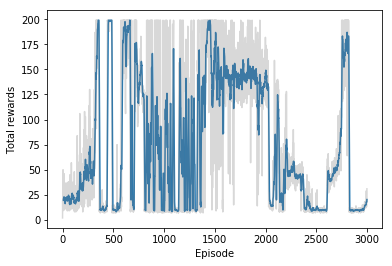

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

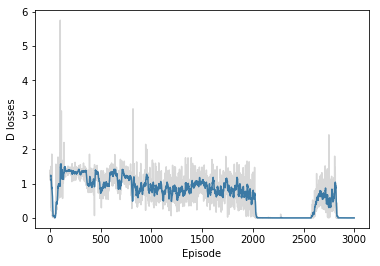

In [22]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

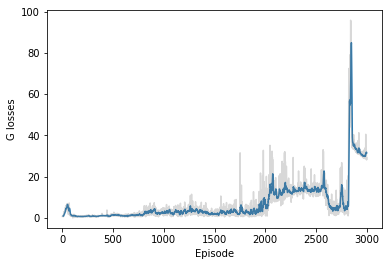

In [23]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

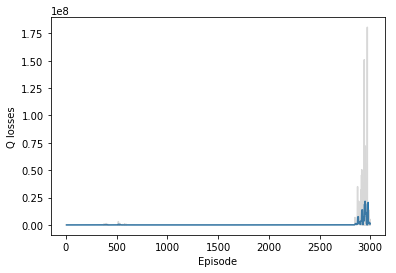

In [24]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
test_episodes = 10
test_max_steps = 1000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [26]:
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.